In [3]:
using Pkg
Pkg.activate(dirname(dirname(pwd())))   # activate MyPackage
# Pkg.instantiate()
using Revise
using LMC
using CairoMakie
using LaTeXStrings

using JLD2
include("/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/model/rhombohedral/plotters.jl")

  Activating project at `~/Documents/Work/PostdocDonosti/Packages/LMC`


Loaded plotting extension


aux_plot_map (generic function with 1 method)

In [4]:
pdPID = 3238850
drudePID = 3285558
lmcPID = 3286797
ahePID = 3291639
spinPID = 3293967#3241713#3251898 #3241713

pdpath = "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/$(pdPID)_merged_data.jld"
pdpresetpath = "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/$(pdPID)_merged_presets.jld"
lmcpath = "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/$(lmcPID)_merged_data.jld"
lmcpresetpath = "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/$(lmcPID)_merged_presets.jld"
spinpath = "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/$(spinPID)_merged_data.jld"
spinpresetpath = "/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/$(spinPID)_merged_presets.jld"

"/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/ClusterDATA/LMC/3293967_merged_presets.jld"

In [10]:
# _, _, _, _, Ezs, νlist, matt = aux_plot_obs(spinpath, spinpresetpath, LMC.plot_lmcspin, flavor_filling = 1)

("3241713", "3238850", "3237618", 10000, Any[-10.0, -9.959919839679358, -9.919839679358718, -9.879759519038076, -9.839679358717435, -9.799599198396793, -9.759519038076153, -9.719438877755511, -9.67935871743487, -9.639278557114228  …  9.639278557114228, 9.67935871743487, 9.719438877755511, 9.759519038076153, 9.799599198396793, 9.839679358717435, 9.879759519038076, 9.919839679358718, 9.959919839679358, 10.0], [-0.25, -0.249, -0.248, -0.247, -0.246, -0.245, -0.244, -0.243, -0.242, -0.241  …  0.241, 0.242, 0.243, 0.244, 0.245, 0.246, 0.247, 0.248, 0.249, 0.25], [-2.1042124903093706e-7 -0.0028331316492393125 … 5.684578131239927e-36 0.0; -0.000800610662449952 -0.000983781220122481 … 1.624215325137591e-33 0.0; … ; -1.7096205135067552e-7 -0.0009896758652929757 … 1.6941600590663126e-33 0.0; -0.02812118206708692 -0.028121413738503215 … 6.007576117623778e-19 0.0])

In [2]:

function lat_figure5(pdpath, pdpresetpath, lmcpath, lmcpresetpath, spinpath, spinpresetpath, Ezval; 
    fontsizetheme = 15)
    with_theme(merge(theme_latexfonts(), Theme(fontsize = fontsizetheme))) do #
        Figure5(pdpath, pdpresetpath, lmcpath, lmcpresetpath, spinpath, spinpresetpath, Ezval, fontsize = fontsizetheme)   
    end
end

using Interpolations, Statistics


#choose solution at boundary region
function interpolate_despike(x,y, threshold)
    good = detect_outliers(y, threshold)
    xg = x[good]
    yg = y[good]
    itp = linear_interpolation(xg, yg, extrapolation_bc = Line())
    return itp.(x)
end

function detect_outliers(data::AbstractVector{<:Real}, threshold::Real)
    n = length(data)
    good = trues(n)
    for i in 2:n-1
        avg_neighbors = (data[i-1] + data[i+1]) / 2
        if abs(data[i] - avg_neighbors) > threshold
            good[i] = false
        end
    end
    return good
end

function despike_forward!(d, threshold)
    data = zeros(length(d))
    n = length(data)
    data[1] = d[1]
    for i in 2:n-1
        left  = data[i-1]      # already filtered
        mid   = d[i]
        right = d[i+1]      # original (not yet filtered)

        avg_neighbors = (left + right) / 2
        deviation = abs(mid - avg_neighbors)

        if deviation > threshold && abs(right)-abs(mid) > threshold && abs(left)-abs(mid) > threshold || deviation > 10threshold
        data[i] = avg_neighbors
        else 
            data[i] = d[i]
        end
    end

    return data
end

function Figure5(pdpath, pdpresetpath, lmcpath, lmcpresetpath, spinpath, spinpresetpath, Ezval = 4; 
    fontsize = 8)
    fig = Figure(size = (600, 600))
    ga = fig[1:2,1:2] = GridLayout()
    ax1 = Axis(ga[1,1], xlabel = L"$\nu\text{ [}10^{12}\text{ cm}^{-2}\text{]}$", ylabel = L"$E_z \text{ [meV]}$", xlabelsize = fontsize +2, ylabelsize = fontsize +2)
    ax2 = Axis(ga[1,2], xlabel = L"$\nu\text{ [}10^{12}\text{ cm}^{-2}\text{]}$", ylabel = L"$E_z \text{ [meV]}$", xlabelsize = fontsize +2, ylabelsize = fontsize +2)
    ax3 = Axis(ga[2,1], xlabel = L"$\nu\text{ [}10^{12}\text{ cm}^{-2}\text{]}$", ylabel = L"$E_z \text{ [meV]}$", xlabelsize = fontsize +2, ylabelsize = fontsize +2)
    ax4 = Axis(ga[2,2], xlabel = L"$\nu\text{ [}10^{12}\text{ cm}^{-2}\text{]}$", ylabel = L"$E_z \text{ [meV]}$", xlabelsize = fontsize +2, ylabelsize = fontsize +2)
    ax5 = Axis(fig[3,1:2],  xlabel = L"$\nu\text{ [}10^{12}\text{ cm}^{-2}\text{]}$", ylabel =  L"$|\sigma_{xxx}|\text{ }[1/T e^2/h]$",  xlabelsize = fontsize +2, ylabelsize = fontsize +2, ylabelpadding = -8)

    ax5.yticks = ([-0.1,0,0.1], ["-0.1", "0", "0.1"])

    hidexdecorations!(ax1, grid = false)
    hidexdecorations!(ax2, grid = false)
    # hidexdecorations!(ax3, grid = false)
    # hidexdecorations!(ax4, grid = false)
    hideydecorations!(ax2, grid = false)
    hideydecorations!(ax4, grid = false)
    
    
    
    #_________________________________________
    # plot_phasediagrams(ax1, pdpath, pdpresetpath; colorlist = missing, axisleg = false)
    
    # cbs = fig[1:2,3] = GridLayout()
    
    hm = plot_lmc(ax1, lmcpath, lmcpresetpath, colorrange = [-0.05, 0.05], 
        absolute = false, flavor_filling = 1)
    hm = plot_lmc(ax2, lmcpath, lmcpresetpath, colorrange = [-0.05, 0.05],
         absolute = false, flavor_filling = 2)
    cb = Colorbar(ga[1,3], hm, label = L"$|\sigma^O_{xxx}|\text{ } [1/T e^2/h]$", 
        labelsize = fontsize +1, vertical = true, labelpadding = -15,
    ticks = ([-0.05,0,0.05], ["-0.05","0","0.05"]), ticklabelpad = 2, 
        ticklabelsize = fontsize, ticksize = 4)
    hm = plot_lmcspin(ax3, spinpath, spinpresetpath, colorrange = [-0.05, 0.05],
         absolute = false, flavor_filling = 1 )
    hm = plot_lmcspin(ax4, spinpath, spinpresetpath, colorrange = [-0.05, 0.05], 
        absolute = false, flavor_filling = 2)
    cb = Colorbar(ga[2,3], hm, label = L"$|\sigma^S_{xxx}|\text{ } [1/T e^2/h]$", labelsize = fontsize +1, 
        vertical = true, labelpadding = -15,
    ticks = ([-0.05,0,0.05], ["-0.05","0","0.05"]), ticklabelpad = 2, ticklabelsize = fontsize, 
        ticksize = 4)


    

    # xmin = -0.7
    # xmax = 0.1
    ymin = 0
    ymax = 10

    # [xlims!(ax, xmin, xmax) for ax in [ax1,ax2,ax3,ax4]]
    [ylims!(ax, ymin, ymax) for ax in [ax1,ax2,ax3,ax4]]



    #_________________________________________

    _, _, _, _, Ezs, νlist, matt = aux_plot_obs(lmcpath, lmcpresetpath, LMC.plot_lmc, flavor_filling = 1)
    _, _, _, _, Ezs, νlist, matts = aux_plot_obs(spinpath, spinpresetpath, LMC.plot_lmcspin, flavor_filling = 1)

    νlist .*= prefactor_filling()/1e12 
    idxEz = argmin(abs.(Ezs .- Ezval))
    lmcorbital_line = matt'[:, idxEz]
    y_interp = interpolate_despike(νlist, lmcorbital_line, 0.01)

    xlims!(ax5, -0.73,0.1)

    lines!(ax5, νlist, y_interp, color = :red)
    lines!(ax5, νlist, -y_interp, color = :blue)

    ylims!(ax5, -0.11, 0.11)


    vspan!(ax5, -0.59,-0.27, color = (:blue, 0.1))
    vspan!(ax5, -0.07,0.1, color = (:gray, 0.2))
    


    lines!(ax1, [-0.73,0], [Ezval, Ezval], linewidth = 1.5, color = :orange)
    lines!(ax2, [-0.73,0], [Ezval, Ezval], linewidth = 1.5, color = :orange)
    lines!(ax3, [-0.73,0], [Ezval, Ezval], linewidth = 1.5, color = :orange)
    lines!(ax4, [-0.73,0], [Ezval, Ezval], linewidth = 1.5, color = :orange)
    
    # lines!(ax5, νlist, fdataorbital)
    #_________________________________________
    Label(ga[1, 1, TopLeft()], "a)",
        fontsize = fontsize,
        padding = (0, 35, -0, 0),
        halign = :right)

    Label(ga[1, 2, TopLeft()], "b)",
    fontsize = fontsize,
    padding = (0, 5, -0, 0),
    halign = :right)

    Label(ga[2, 1, TopLeft()], "c)",
    fontsize = fontsize,
    padding = (0, 35, -0, 0),
    halign = :right)

    Label(ga[2, 2, TopLeft()], "d)",
    fontsize = fontsize,
    padding = (0, 5, -0, 0),
    halign = :right)

    Label(fig[3, 1:2, TopLeft()], "e)",
    fontsize = fontsize,
    padding = (0, 35, -0, 0),
    halign = :right)

    colgap!(ga, 10)
    rowgap!(ga, 10)
    rowgap!(fig.layout, 0) 
    fig
end

LoadError: LoadError: UndefVarError: `@L_str` not defined
in expression starting at /Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figure_spin_lmc.ipynb:59

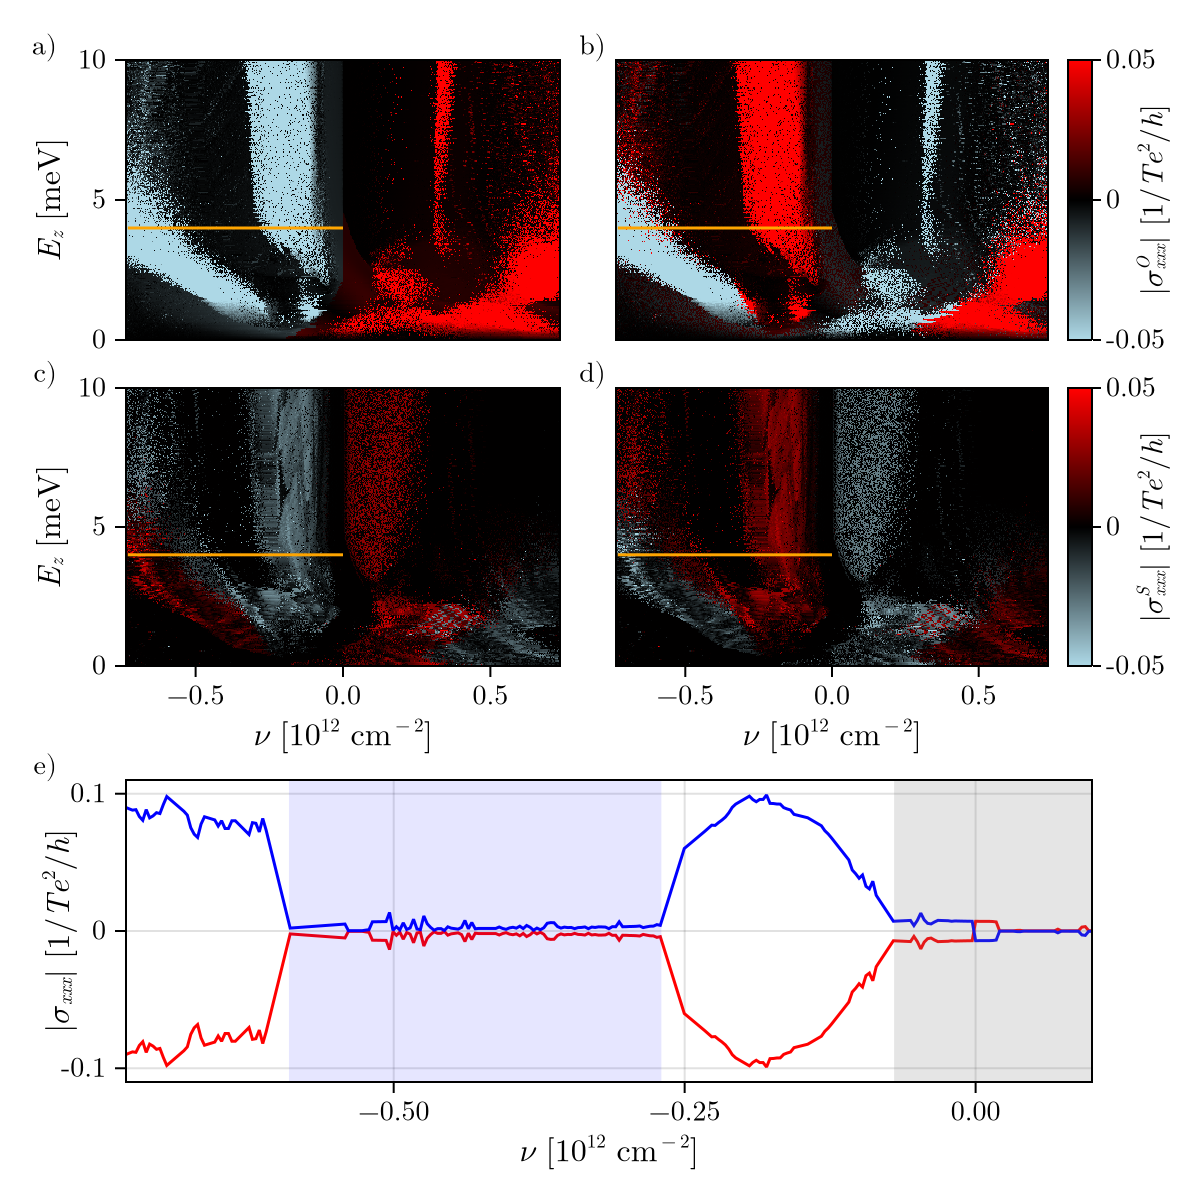

In [289]:
Ezval = 4
fig5 = lat_figure5(pdpath, pdpresetpath, lmcpath, lmcpresetpath, spinpath, spinpresetpath, Ezval; 
    fontsizetheme = 14)

In [290]:
v = "v1"
save("/Users/fernandopenaranda/Documents/Work/PostdocDonosti/Packages/LMC/src/Paper/Figures/Figure5$(v).pdf", fig5)

CairoMakie.Screen{PDF}


In [155]:
# _, _, _, _, Ezs, νlist, matt = aux_plot_obs(lmcpath, lmcpresetpath, LMC.plot_lmc, flavor_filling = 1)
# _, _, _, _, Ezs, νlist, matts = aux_plot_obs(spinpath, spinpresetpath, LMC.plot_lmcspin, flavor_filling = 1)

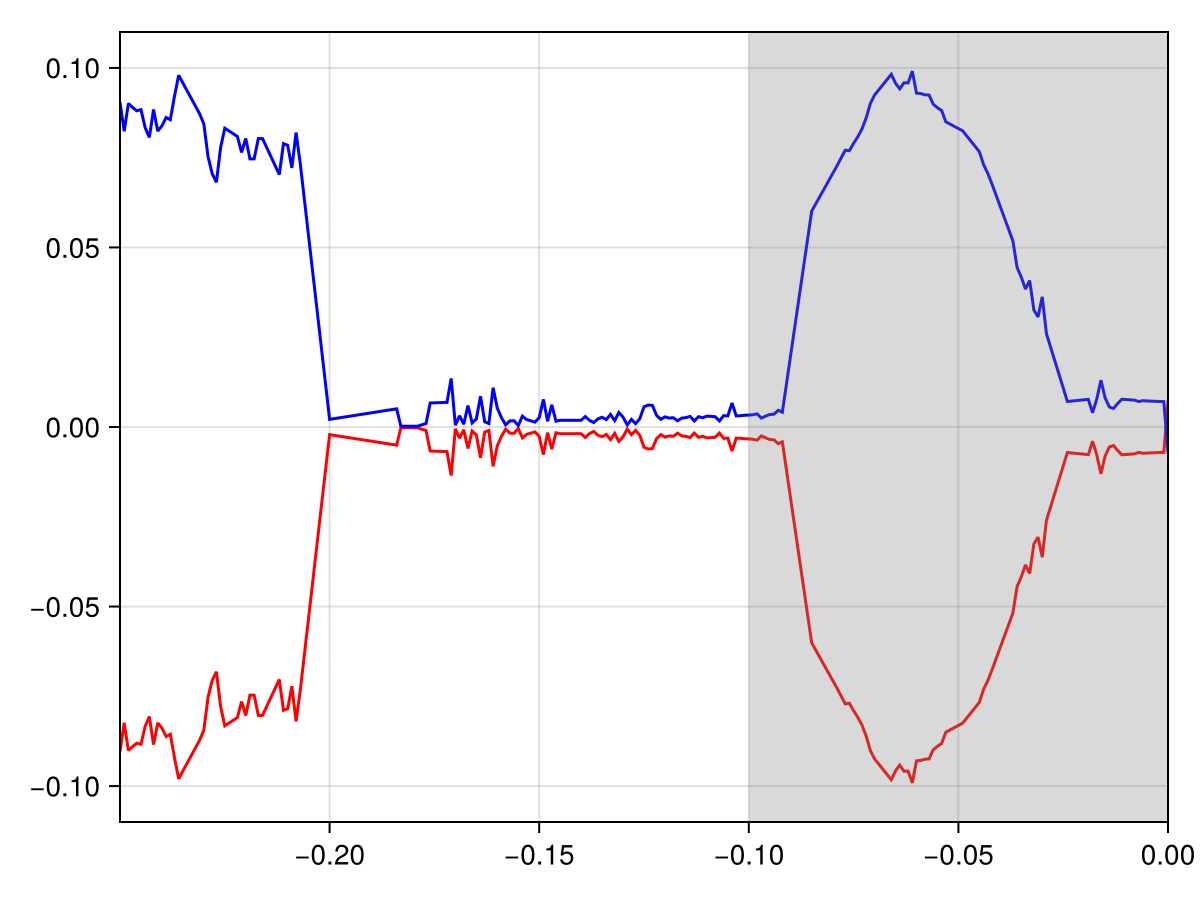

In [229]:

Ezval = 4
idxEz = argmin(abs.(Ezs .- Ezval))
lmcorbital_line = matt'[:, idxEz]
y_interp = interpolate_despike(νlist, lmcorbital_line, 0.01)
# despike_forward!(y_interp, 1)

fig = Figure()
ax = Axis(fig[1,1])
# scatter!(ax, νlist, lmcorbital_line)
lines!(ax, νlist, y_interp, color = :red)
lines!(ax, νlist, -y_interp, color = :blue)
vspan!(ax, -0.1,0, color = (:gray, 0.3))

xlims!(ax, -0.25, -0.0)
ylims!(ax, -0.11, 0.11)
fig


In [198]:
# function repair_spikes(data, threshold)

#     n = length(data)
#     repaired = copy(data)

#     for i in 2:n-1
#     avg = (repaired[i-1] + data[i+1]) / 2
#     if abs(data[i] - avg) > threshold
#     repaired[i] = avg
#     end
# end

# return repaired
# end

# function interpolate_repaired(x, y, threshold)
#     y_repaired = repair_spikes(y, threshold)
#     itp = linear_interpolation(x, y_repaired, extrapolation_bc = Line())
#     return itp.(x)
# end

interpolate_repaired (generic function with 3 methods)